In [2]:
import pandas as pd
import seaborn as sns
from scipy import stats

# anova model from formula
from statsmodels.formula.api import ols
# anova table from ols model
from statsmodels.stats.anova import anova_lm
# for qqplot
import statsmodels.api as sm
# tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [10]:
data = pd.read_csv('Customer_Segmentation.csv')
data.head()

,Unnamed: 0,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,460394,Female,No,32,Yes,Healthcare,9.0,Low,3.0,Cat_6,D
1,1,461798,Female,No,56,Yes,Artist,0.0,Low,1.0,Cat_6,A
2,2,464976,Male,Yes,75,No,Lawyer,1.0,Low,1.0,Cat_4,D
3,3,462104,Male,Yes,39,No,Entertainment,9.0,Low,2.0,Cat_3,D
4,4,464829,Male,No,22,No,Healthcare,9.0,Low,5.0,Cat_4,D


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       10695 non-null  int64  
 1   ID               10695 non-null  int64  
 2   Gender           10695 non-null  object 
 3   Ever_Married     10505 non-null  object 
 4   Age              10695 non-null  int64  
 5   Graduated        10593 non-null  object 
 6   Profession       10533 non-null  object 
 7   Work_Experience  9597 non-null   float64
 8   Spending_Score   10695 non-null  object 
 9   Family_Size      10247 non-null  float64
 10  Var_1            10587 non-null  object 
 11  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1002.8+ KB


In [8]:
# Предварительный анализ данных
# Проверка наличия пропущенных значений
missing_values = data.isnull().sum()
print("Пропущенные значения:")
print(missing_values)

Пропущенные значения:
Unnamed: 0            0
ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64


In [12]:
# удаляем наблюдения с пропущенными значениями
data = data[data.Graduated.isna() != True]

<Axes: xlabel='Segmentation', ylabel='Age'>

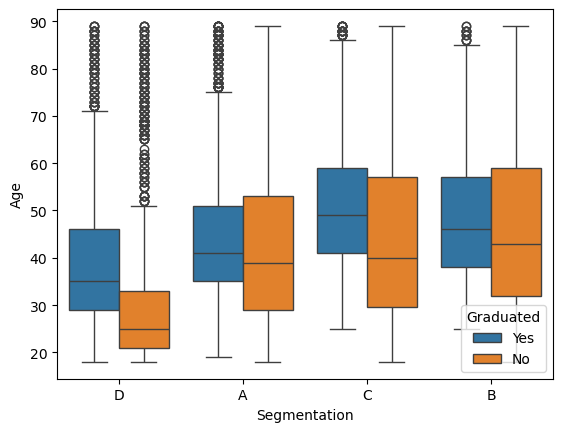

In [18]:
sns.boxplot(data=data, x='Segmentation', y='Age', hue='Graduated')

<b>Шаг 1. Постановка гипотез:</b>

$H_0$: Возраст и уровень образования не влияют на сегмент пользователя

$H_1$: Возраст и уровень образования влияют на сегмент пользователя

<b>Шаг 2. Выбор уровня значимости:</b>
$$\alpha = 0.05$$

In [28]:
#one-way anova
one_way = ols('Age ~ Segmentation', data).fit()
anova_lm(one_way)

,df,sum_sq,mean_sq,F,PR(>F)
Segmentation,3.0,3.541179e+05,118039.307058,477.952227,2.798107e-291
Residual,10589.0,2.615153e+06,246.968840,NaN,NaN


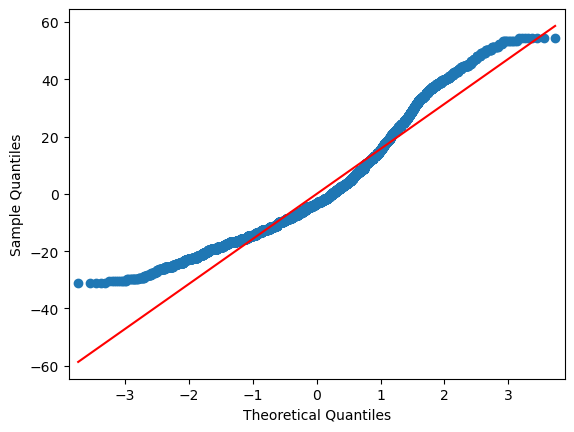

In [30]:
#qq-plot, проверяем нормальность остатков
sm.qqplot(one_way.resid, line='s');

In [32]:
#разделяем данные по сегментам, чтобы провести тест Левена
groups = []
for group_id, group in data.groupby(['Segmentation']):
    groups.append(group.Age)

In [34]:
#тест Левена
stats.bartlett(*groups)

BartlettResult(statistic=43.343925439063604, pvalue=2.0801005394433813e-09)

In [36]:
#апостериорный анализ
print(pairwise_tukeyhsd(endog=data.Age, groups=data.Segmentation, alpha=0.05))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     A      B   3.2986    0.0   2.1722    4.425   True
     A      C   4.8721    0.0   3.7504   5.9938   True
     A      D  -9.6403    0.0 -10.7026  -8.5781   True
     B      C   1.5735 0.0029   0.4084   2.7386   True
     B      D -12.9389    0.0 -14.0468  -11.831   True
     C      D -14.5124    0.0 -15.6156 -13.4093   True
------------------------------------------------------


In [38]:
#two-way anova
two_way = ols('Age ~ Segmentation + Graduated + Segmentation:Graduated', data).fit()
anova_lm(two_way)

,df,sum_sq,mean_sq,F,PR(>F)
Segmentation,3.0,3.541179e+05,118039.307058,493.786071,2.474155e-300
Graduated,1.0,5.609825e+04,56098.251088,234.672125,2.079184e-52
Segmentation:Graduated,3.0,2.871598e+04,9571.992294,40.041886,1.011249e-25
Residual,10585.0,2.530339e+06,239.049487,NaN,NaN


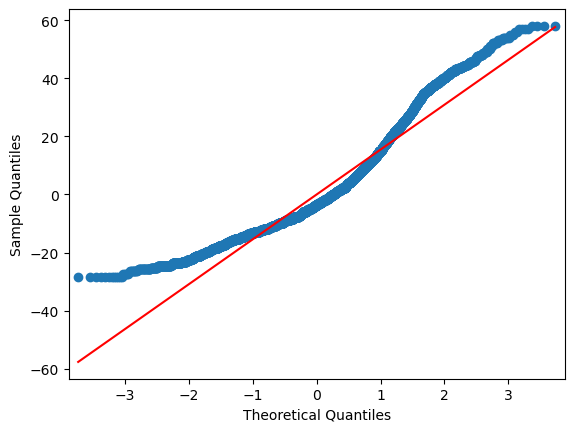

In [40]:
#qq-plot, проверяем нормальность остатков
sm.qqplot(two_way.resid, line='s');


In [42]:
#разделяем данные по сегментам и образованию, чтобы провести тест Левена
groups = []
for group_id, group in data.groupby(['Segmentation', 'Graduated']):
    groups.append(group.Age)

In [44]:
#тест Левена
stats.bartlett(*groups)

BartlettResult(statistic=233.96193752334233, pvalue=7.142053955616402e-47)

In [47]:
#апостериорный анализ
data['combination'] = data.Segmentation + '/' + data.Graduated
print(pairwise_tukeyhsd(endog=data.Age.astype('float'), groups=data.combination, alpha=0.05))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  A/No  A/Yes   1.3896 0.2931  -0.4414   3.2206  False
  A/No   B/No   2.8664 0.0037   0.5767   5.1561   True
  A/No  B/Yes   4.6981    0.0   2.8575   6.5387   True
  A/No   C/No   0.2673    1.0  -2.3012   2.8358  False
  A/No  C/Yes   7.1141    0.0   5.3191   8.9092   True
  A/No   D/No -12.5708    0.0 -14.3916 -10.7499   True
  A/No  D/Yes  -3.1845    0.0  -5.1587  -1.2103   True
 A/Yes   B/No   1.4768 0.3962  -0.6262   3.5798  False
 A/Yes  B/Yes   3.3085    0.0   1.7061   4.9109   True
 A/Yes   C/No  -1.1223 0.8505  -3.5258   1.2813  False
 A/Yes  C/Yes   5.7245    0.0   4.1747   7.2744   True
 A/Yes   D/No -13.9604    0.0 -15.5401 -12.3806   True
 A/Yes  D/Yes  -4.5741    0.0  -6.3283  -2.8199   True
  B/No  B/Yes   1.8317 0.1452  -0.2796   3.9431  False
  B/No   C/No   -2.599 0.0843   -5.368     0.17  False
  B/No  C/